In [3]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [4]:
import numpy as np
import pandas as pd

In [5]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [6]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [7]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [8]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [9]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [10]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [11]:
#inspect measurement schema
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
 # Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
engine.execute("select * from Measurement limit 10").fetchall()
session.query(func.count(Measurement.date)).all()

# Calculate the date 1 year ago from the last data point in the database
current_year=session.query(func.max(Measurement.date)).all()
current_year

# Perform a query to retrieve the data and precipitation scores
precip_df = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= "2016-08-01").\
        filter(Measurement.date <= "2017-08-01").\
        group_by(Measurement.date).all()
precip_df

precip_df = pd.DataFrame(precip_df, columns = ['date', 'precipitation'])

#set index
precip_df.set_index('date', inplace = True)

In [14]:
# Save the query results as a Pandas DataFrame and set the index to the date column
precip_df = precip_df.sort_values(by='date')
precip_df.head()

,precipitation
date,
2016-08-01,0.08
2016-08-02,0.05
2016-08-03,0.00
2016-08-04,0.04
2016-08-05,0.01


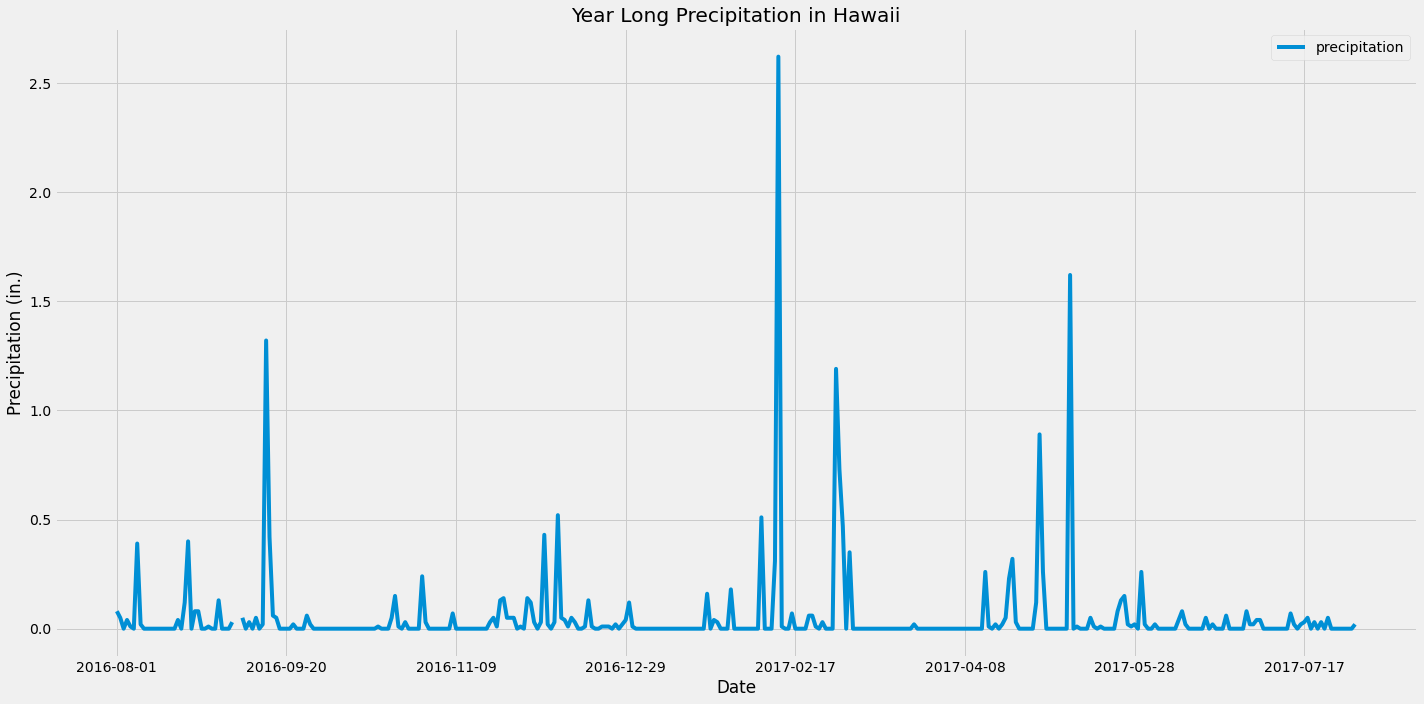

In [41]:
# Use Pandas Plotting with Matplotlib to plot the data
fig, ax = plt.subplots(figsize = (20, 10))
precip_df.plot(ax = ax, x_compat = True)

#title and labels
ax.set_xlabel('Date')
ax.set_ylabel('Precipitation (in.)')
ax.set_title("Year Long Precipitation in Hawaii")

plt.savefig("Images/precipitation.png")

#plot
plt.tight_layout()
plt.show()



In [42]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_df.describe()

,precipitation
count,364.000000
mean,0.051758
std,0.206449
min,0.000000
25%,0.000000
50%,0.000000
75%,0.020000
max,2.620000


In [17]:
# Design a query to show how many stations are available in this dataset?
total_stations = session.query(func.count(Station.station)).all()
total_stations

[(9)]

In [18]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_counts = (session.query(Measurement.station, func.count(Measurement.station))
                        .group_by(Measurement.station)
                        .order_by(func.count(Measurement.station).desc())
                        .all())
station_counts

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [19]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
most_active_station = 'USC00519281'
temps = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active_station).all()
temps

[(54.0, 85.0, 71.66378066378067)]

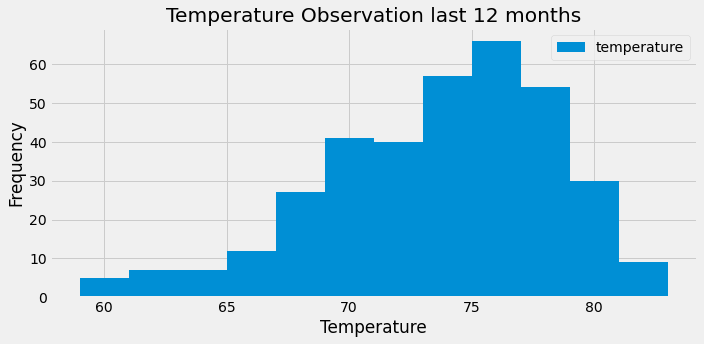

In [43]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_observation = session.query(Measurement.date, Measurement.tobs).filter(Measurement.station == most_active_station).\
    filter(func.strftime("%Y-%m-%d", Measurement.date) >= dt.date(2016, 8, 20)).all()

#save as a data frame
temp_observation_df = pd.DataFrame(temp_observation, columns = ['date', 'temperature'])

fig, ax = plt.subplots()
temp_observation_df.plot.hist(bins = 12, ax = ax, figsize=(10,5))

#labels
ax.set_xlabel('Temperature')
ax.set_ylabel('Frequency')
ax.set_title("Temperature Observation last 12 months")

#save figure
plt.savefig("Images/histogram.png")

#plot
plt.tight_layout()
plt.show()



## Bonus Challenge Assignment

In [22]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [23]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_temps = calc_temps('2017-08-20', '2017-08-28')
trip_temps

[(76.0, 79.85714285714286, 82.0)]

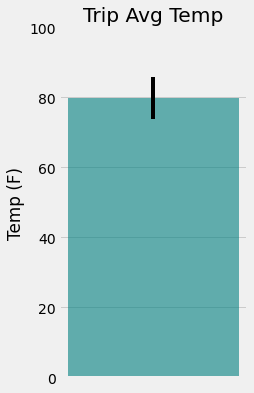

In [44]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
min_temp = trip_temps[0][0]
avg_temp = trip_temps[0][1]
max_temp = trip_temps[0][2]

min_error = avg_temp - min_temp
max_error = max_temp - avg_temp

plt.figure(figsize=(3,6))
plt.bar(0, avg_temp, yerr=[max_temp-min_temp], color = 'teal', alpha=.6)
plt.title('Trip Avg Temp')
plt.ylim(0,100)
plt.ylabel('Temp (F)')
plt.xticks([])

#save figure
plt.savefig("Images/trip_avg_temp_plot.png")

#plot
plt.show()

In [32]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

start_date = '2017-08-20'
end_date = '2017-08-28'

s = session.query(Station.station,
                  func.sum(Measurement.prcp),
                  Station.name,
                  Station.elevation,                                    
                  Station.latitude,
                  Station.longitude)\
.filter(Measurement.station == Station.station)\
.filter(Measurement.date >= start_date)\
.filter(Measurement.date <= end_date)\
.group_by(Station.station)\
.order_by(func.sum(Measurement.prcp).desc())

for row in s:
    rain="{0:.2f}".format(row[1])
    print (f"Station:  {row[0]}\n    Rainfall:  {rain}  \n    Location:  {row[2]}\n    Elevation:  {row[3]}  \
    Latitude:  {row[4]}  Longitude:  {row[5]}")
    print()


Station:  USC00516128
    Rainfall:  1.51  
    Location:  MANOA LYON ARBO 785.2, HI US
    Elevation:  152.4      Latitude:  21.3331  Longitude:  -157.8025

Station:  USC00519523
    Rainfall:  0.08  
    Location:  WAIMANALO EXPERIMENTAL FARM, HI US
    Elevation:  19.5      Latitude:  21.33556  Longitude:  -157.71139

Station:  USC00514830
    Rainfall:  0.03  
    Location:  KUALOA RANCH HEADQUARTERS 886.9, HI US
    Elevation:  7.0      Latitude:  21.5213  Longitude:  -157.8374

Station:  USC00519397
    Rainfall:  0.00  
    Location:  WAIKIKI 717.2, HI US
    Elevation:  3.0      Latitude:  21.2716  Longitude:  -157.8168



In [33]:
from sqlalchemy import extract  
trip_month=8
trip_days=range(1, 16)
for i in range(1, 16):
    subquery=session.query(Measurement.date).filter(extract('month', Measurement.date)==trip_month).\
             filter(extract('day', Measurement.date)== i ).group_by(Measurement.date).order_by(Measurement.date).all()
subquery

[('2010-08-15'),
 ('2011-08-15'),
 ('2012-08-15'),
 ('2013-08-15'),
 ('2014-08-15'),
 ('2015-08-15'),
 ('2016-08-15'),
 ('2017-08-15')]

In [34]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [35]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

dates=[]
daily_normals_Three_AVG=[]
daily_normals_TMAX=[]
daily_normals_TMIN=[]
daily_normals_TAVG=[]

trip_month=8
trip_days=range(1, 16)

def daily_normals():
    
    for i in range(1,16):
        results=session.query(Measurement.date.label("dates"), func.max(Measurement.tobs).label("max_tobs"),\
                             func.min(Measurement.tobs).label("min_tobs"),func.avg(Measurement.tobs).label("avg_tobs")).\
                             filter(extract('month', Measurement.date)==trip_month).\
                             filter(extract('day', Measurement.date)== i ).group_by(Measurement.date).order_by(Measurement.date)
        results
        for res in results.all():
             print( res)
        
        res
        TMAX = res.max_tobs
        TMIN= res.min_tobs
        TAVG= res.avg_tobs
        Date= res.dates
        
        data = [TMAX, TMIN, TAVG]
        #avg = [float(sum(col))/len(col) for col in zip(*data)]

        dates.append(Date)
        #daily_normals_Three_AVG.append(avg)
        daily_normals_TMAX.append(TMAX)
        daily_normals_TMIN.append(TMIN)
        daily_normals_TAVG.append(TAVG)
        
daily_normals()


('2010-08-01', 77.0, 71.0, 73.42857142857143)
('2011-08-01', 78.0, 67.0, 73.375)
('2012-08-01', 79.0, 71.0, 75.85714285714286)
('2013-08-01', 79.0, 75.0, 76.83333333333333)
('2014-08-01', 83.0, 73.0, 77.42857142857143)
('2015-08-01', 79.0, 73.0, 77.4)
('2016-08-01', 78.0, 73.0, 76.16666666666667)
('2017-08-01', 77.0, 72.0, 74.5)
('2010-08-02', 76.0, 70.0, 73.22222222222223)
('2011-08-02', 77.0, 70.0, 73.625)
('2012-08-02', 78.0, 68.0, 73.5)
('2013-08-02', 78.0, 70.0, 74.57142857142857)
('2014-08-02', 81.0, 73.0, 77.71428571428571)
('2015-08-02', 84.0, 76.0, 80.0)
('2016-08-02', 80.0, 72.0, 76.57142857142857)
('2017-08-02', 83.0, 73.0, 79.0)
('2010-08-03', 77.0, 70.0, 73.11111111111111)
('2011-08-03', 78.0, 71.0, 75.25)
('2012-08-03', 78.0, 72.0, 74.57142857142857)
('2013-08-03', 79.0, 72.0, 76.66666666666667)
('2014-08-03', 83.0, 74.0, 78.33333333333333)
('2015-08-03', 85.0, 75.0, 80.0)
('2016-08-03', 82.0, 74.0, 78.42857142857143)
('2017-08-03', 81.0, 76.0, 79.0)
('2010-08-04', 77.0, 

In [36]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
Daily_normals_df= pd.DataFrame({'Date': dates, 'TMAX': daily_normals_TMAX, 'TMIN': daily_normals_TMIN,'TAVG': daily_normals_TAVG,})
Daily_normals_df.set_index('Date', inplace=True, )
Daily_normals_df.head()

,TMAX,TMIN,TAVG
Date,,,
2017-08-01,77.0,72.0,74.5
2017-08-02,83.0,73.0,79.0
2017-08-03,81.0,76.0,79.0
2017-08-04,82.0,77.0,80.0
2017-08-05,82.0,77.0,80.0


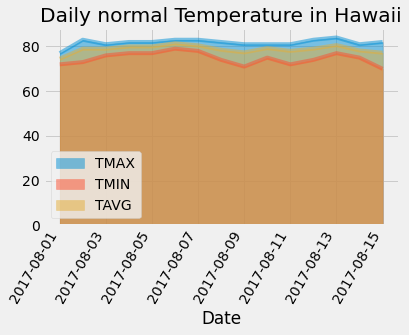

In [45]:
# Plot the daily normals as an area plot with `stacked=False`
Daily_normals_df.plot.area(stacked=False, title='Daily normal Temperature in Hawaii')
ax.set_xlabel('Date')
plt.tight_layout()
plt.xticks(rotation=60,horizontalalignment='right')
plt.savefig('Images/Daily Temp in Hawaii.png', bbox_inches = 'tight')

plt.show()
